[View in Colaboratory](https://colab.research.google.com/github/vimalrajayyappan/Path_Planning/blob/master/Hybrid_Astar.ipynb)

In [0]:
import numpy as np
import math as MT
import matplotlib.pyplot as plt

### STATE CLASS
class state:
  def __init__(self,x,y,theta,g,f,h,steer):
    self.x=x
    self.y=y
    self.theta=theta
    self.g=g
    self.f=f
    self.h=h
    self.steer=steer

### START NODE
class start:
    def __init__(self, x, y, theta):
        self.x = x
        self.y = y
        self.theta = theta
### GOAL NODE        
class goal:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
### LINK INDEX AND STATE        
class link:
    def __init__(self, inp_state, inp_index,vehicle_points_obj):
        self.state = inp_state
        self.index = inp_index
        self.vehicle_points_obj=vehicle_points_obj
        
        
### INPUT VEHICLE CO-ORDINATES AS NP.ARRAY([top_left,top_right,bottom_right,bottom_left])
class vehicle_points():
  def __init__(self,input_co_ordinates):
    self.input_co_ordinates=input_co_ordinates
    self.center=np.array([(input_co_ordinates[0][0]+input_co_ordinates[2][0])/2.0,(input_co_ordinates[0][1]+input_co_ordinates[2][1])/2.0])

In [0]:
###CONSTANTS
max_angle = 0.785398 #45Deg
min_angle = -0.785398 #-45Deg
free_space=0
locked_space=1
number_of_steers=3
steer_offset=10*np.pi/180
speed = 1
length_of_vehicle = 1

### GRID MAKING 
grid_x_m = 40
grid_y_m = 40

### FOR CELL DIVISION
coll_cell_side = 1.0
grid_on_x = np.int( np.ceil(grid_x_m/coll_cell_side) )
grid_on_y = np.int( np.ceil(grid_y_m/coll_cell_side) )

### FIT ZEROS
grid = np.zeros((grid_on_x,grid_on_y-1),np.int)

In [0]:

### AUGMENT DELTA +/- GIVEN OFFSET
def delta_augmentation(delta, numbers, offset):
    delta_list = []
    delta_list.append(delta)
    delta_calc_add=delta_calc_sub = delta
    for i in range(0 ,numbers):
        delta_calc_add += offset
        delta_calc_sub -= offset
        if delta_calc_add < max_angle:
            delta_list.append(delta_calc_add)
        if delta_calc_sub > min_angle:
            delta_list.append(delta_calc_sub)
    return delta_list

### TRANSFORM VEHICLE CO-ORDINATES 
def transform_vehicle_co_ordinates(vehicle_point_object,next_state,angle_of_rotation):
    displaced_matrix = np.array([next_state[0]-vehicle_point_object.center[0],next_state[1]-vehicle_point_object.center[1]])
    transformed_matrix=np.add(vehicle_point_object.input_co_ordinates,displaced_matrix)
    return rotate_vehicle_co_ordinates(vehicle_points(transformed_matrix),angle_of_rotation)
  
### ROTATE VEHICLE CO-ORDINATES     
def rotate_vehicle_co_ordinates(vehicle_point_object,angle_of_rotation):
    rotation_matrix = np.array([[np.cos(angle_of_rotation), np.sin(angle_of_rotation)], 
                                [-np.sin(angle_of_rotation), np.cos(angle_of_rotation)]])
    return np.add(vehicle_point_object.center,np.matmul(np.subtract(vehicle_point_object.input_co_ordinates,vehicle_point_object.center), rotation_matrix))

def euclidean_distance(start_point,end_point):
  return np.sqrt((end_point[0]-start_point[0])**2 +(end_point[1]-start_point[1])**2)

def normalize_theta(theta):
  if(theta<0):
    theta+=(2*np.pi)
  elif(theta>2*np.pi):
    theta%=(2*np.pi)
  return theta

def new_state_transition(present_state,speed,delta,dt,goal):
  omega = speed/length_of_vehicle * np.tan(delta)
  dX    = speed * np.cos(present_state.theta) * dt
  dY    = speed * np.sin(present_state.theta) * dt
  nextX = present_state.x + dX
  nextY = present_state.y + dY
  nextTheta = normalize_theta(present_state.theta+(omega*dt))
  nextG = present_state.g + np.sqrt(dX*dX + dY*dY)
  nextH = present_state.h + euclidean_distance([nextX,nextY],[goal.x,goal.y])
  nextF = nextG+nextH
  nextSteer = delta  #######################
  nextState = state(nextX,nextY,nextTheta,nextG,nextF,nextH,nextSteer)
  return nextState
  
  
def is_within_grid(x,y):
  return (x>0 and x<grid_x_m and y>0 and y<grid_y_m)

def is_closed(x,y):
  return grid[x][y]!=free_space

def theta_to_stack_number(theta):
  new = (theta+2*np.pi)%(2*np.pi)
  stack_number = round(new*90/2*np.pi)%90
  return int(stack_number)

def idx(value):
  return int(MT.floor(value))

def is_vehicle_in_safe_position(vehicle_points):
  count=0
  for point in vehicle_points.input_co_ordinates:
    if(is_within_grid( idx(point[0]),idx(point[1])) and  
       (not is_closed(idx(point[0]),idx(point[1])))):
      count+=1
    else:
      return False
  return True

def is_goal_reached(start,goal):
  result=False
  if(idx(start[0])==idx(goal[0]) and idx(start[1])==idx(goal[1])):
    result=True
  
  return result 
  

In [0]:
#trace_link = link(path_state, -1 )
#trace_list.append(trace_link)

###$
path_x = []
path_y = []
path_h = []
path_x.append( current_state.x )
path_y.append( current_state.y )
NUM_THETA_CELLS = 90
closed = np.array([[[free_space for x in range(grid_on_x)] for y in range(grid_on_y)] for cell in range(NUM_THETA_CELLS)])

In [0]:
def hybrid_A_star_search(current_state,goal,vehicle_pt_obj,number_of_steers=7,steer_offset=5*np.pi/180):
  open_list = []
  NUM_THETA_CELLS = 90
  path_link = link( current_state, 0, vehicle_pt_obj )
  open_list.append( path_link )
  
  stack_num = theta_to_stack_number(current_state.theta)
  closed[stack_num][idx(current_state.x)][idx(current_state.y)] = locked_space
  goal_reached = False
  speed = 1
  dt = 1
  
  while len(open_list)>0 and (not goal_reached):
    open_list.sort(key=lambda state_srt : float(state_srt.state.f))
    path_link = open_list.pop(0)
    
    path_state = path_link.state
    path_index = path_link.index
    vehicle_pt_obj=path_link.vehicle_points_obj
    
    if(is_goal_reached([path_state.x,path_state.y],[goal.x,goal.y])):
      goal_reached=True
      print("goal_reached")
      return
    
    delta_angles = delta_augmentation( delta=path_state.steer, numbers=number_of_steers,offset=steer_offset)
    
    for angle in delta_angles:
      new_state = new_state_transition( path_state, speed, angle, dt, goal )
      stack_num = theta_to_stack_number(new_state.theta)
      if( is_within_grid( idx( new_state.x ),idx( new_state.y )) 
         and ( not is_closed( idx(new_state.x ),idx( new_state.y )))
         and closed[stack_num][idx( new_state.x )][idx( new_state.y )] != locked_space):
        
        new_vehicle_pt_obj=vehicle_points(transform_vehicle_co_ordinates(vehicle_pt_obj, [new_state.x,new_state.y],new_state.theta ))
        ####################### iterating through every points?
        if(is_vehicle_in_safe_position(new_vehicle_pt_obj)):
          ####################### use of index in link?
          new_link=link(new_state,path_index+1,new_vehicle_pt_obj)
          open_list.append(new_link)
          closed[stack_num][idx( new_state.x )][idx( new_state.y )]=locked_space
          #############WHY plots use rectangles
          plt.plot([path_state.x,new_state.x],[path_state.y,new_state.y])
          #print('stack_num: ',stack_num,'angle',angle*180/np.pi, 'frst_state: ',[path_state.x,path_state.y],'next_state: ',[new_state.x,new_state.y])


KeyboardInterrupt: ignored

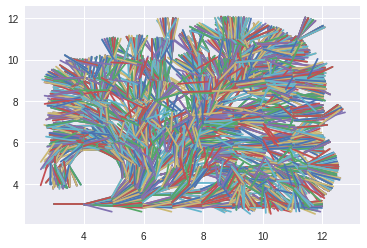

In [183]:
if __name__== "__main__":
  vehicle_pt_obj = vehicle_points(np.array([[1.5,1.5],[1.5,4.5],[4.5,4.5],[4.5,1.5],[1.5,2.5],[1.5,3.5],
                           [2.5,1.5],[2.5,2.5],[2.5,3.5],[2.5,4.5],[3.5,1.5],[3.5,2.5],
                           [3.5,3.5],[3.5,4.5],[4.5,2.5],[4.5,3.5]]))
  current_state = state(vehicle_pt_obj.center[0], vehicle_pt_obj.center[1], 0.0, 0.0, 0.0, 0.0, 0.0)
  goal_node = goal( 12, 12 )
  hybrid_A_star_search(current_state,goal_node,vehicle_pt_obj, 4, 0.0872665 )
  